Plot saved to comparison_prediction_plot.png


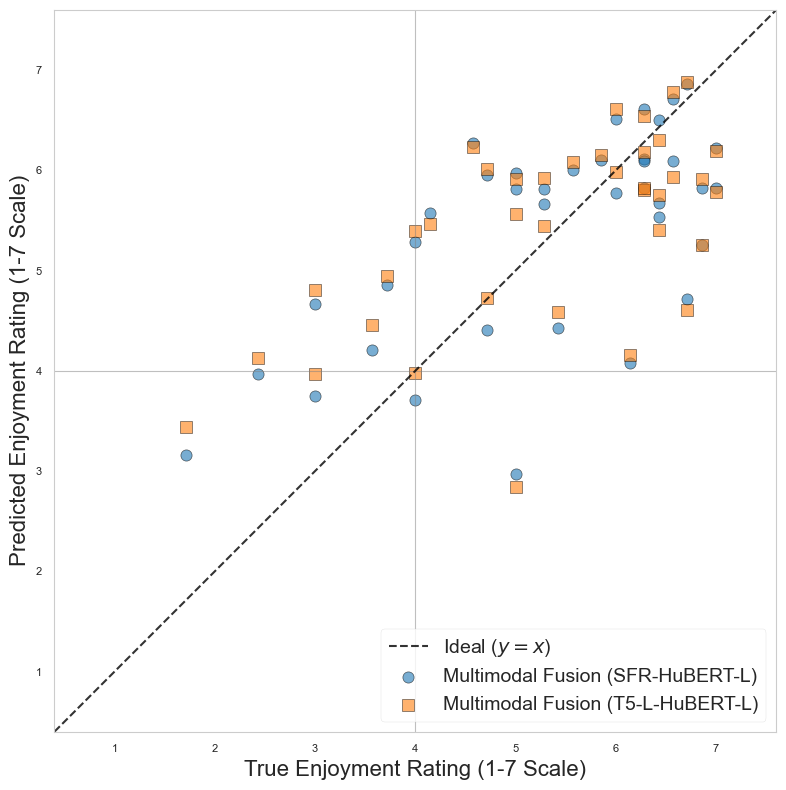

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import io # Required if reading string data

# --- Function Definition ---

def plot_predictions_vs_true_enhanced(
    true_values,
    model_predictions, # Changed: Now expects a list of tuples: [(model_name, predictions), ...]
    title='Model Performance: Predictions vs. True Values',
    xlabel='True Values',
    ylabel='Predicted Values',
    figsize=(8, 8), # Slightly larger figure
    show_regression_line=False,
    show_metrics=True,
    point_size=65,
    save_path=None,
    show_plot=True,
    style_context="seaborn-v0_8-paper",
    grid_style='whitegrid',
    markers=None, # Optional list of markers
    colors=None   # Optional list of colors
    ):
    """
    Creates an enhanced scatter plot comparing predicted vs. true values for one or more models,
    optimized for academic publications. Includes optional regression lines and
    performance metrics (R², MAE, RMSE, Pearson r, p-value, N) for each model.

    Args:
        true_values (list, np.array, or pd.Series): The actual target values.
        model_predictions (list): A list of tuples, where each tuple contains:
                                  (model_name (str), predicted_values (list, np.array, or pd.Series)).
        title (str, optional): The title for the plot.
        xlabel (str, optional): The label for the x-axis.
        ylabel (str, optional): The label for the y-axis.
        figsize (tuple, optional): The figure size (width, height) in inches. Defaults to (8, 8).
        show_regression_line (bool, optional): Plot the linear regression line for each model. Defaults to False.
        show_metrics (bool, optional): Calculate and display R², MAE, RMSE, Pearson r, p-value, N for each model. Defaults to True.
        point_size (int, optional): Size of the scatter plot points. Defaults to 45.
        save_path (str, optional): Path to save the plot image file. Defaults to None.
        show_plot (bool, optional): Display the plot immediately. Defaults to True.
        style_context (str, optional): Seaborn style and context string. Defaults to "seaborn-v0_8-paper".
        grid_style (str, optional): Seaborn grid style. Defaults to "whitegrid".
        markers (list, optional): A list of matplotlib markers to cycle through for different models. Defaults to None (uses default cycle).
        colors (list, optional): A list of matplotlib colors to cycle through for different models. Defaults to None (uses Seaborn's default palette).

    Returns:
        matplotlib.axes._axes.Axes: The Axes object of the plot for further customization if needed.
                                    Returns None if plotting is skipped or inputs are empty.

    Requires: matplotlib, numpy, pandas (for example usage), seaborn, scikit-learn, scipy
    """
    # Ensure true_values is array-like
    try:
        true_vals_arr = np.array(true_values).flatten()
        if len(true_vals_arr) == 0:
            print("Warning: 'true_values' array is empty. Cannot generate plot.")
            return None
    except Exception as e:
        raise TypeError(f"'true_values' must be convertible to a numpy array. Error: {e}")

    # Validate model_predictions structure and lengths
    if not isinstance(model_predictions, list) or not all(isinstance(item, tuple) and len(item) == 2 for item in model_predictions):
         raise TypeError("'model_predictions' must be a list of (model_name, predicted_values) tuples.")

    processed_predictions = []
    for i, (name, preds) in enumerate(model_predictions):
        if not isinstance(name, str):
            raise TypeError(f"Model name at index {i} must be a string.")
        try:
            pred_vals_arr = np.array(preds).flatten()
        except Exception as e:
            raise TypeError(f"Predicted values for model '{name}' must be convertible to numpy arrays. Error: {e}")

        if len(true_vals_arr) != len(pred_vals_arr):
            raise ValueError(f"Length mismatch: 'true_values' ({len(true_vals_arr)}) and predictions for model '{name}' ({len(pred_vals_arr)}).")

        processed_predictions.append({'name': name, 'predictions': pred_vals_arr})

    if not processed_predictions:
        print("Warning: No valid model predictions provided. Cannot generate plot.")
        return None

    num_models = len(processed_predictions)
    if len(true_vals_arr) < 2: # Need at least 2 points for correlation/regression
        print("Warning: Need at least 2 data points. Skipping metrics and regression lines.")
        show_metrics = False
        show_regression_line = False

    # Apply Seaborn styling
    with plt.style.context(style_context):
        sns.set_style(grid_style)
        fig, ax = plt.subplots(figsize=figsize)

        # Central gridlines (custom)
        ax.grid(False) # Disable default grid
        central_x = 4 # Adjust if needed
        central_y = 4 # Adjust if needed
        ax.axhline(y=central_y, color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')
        ax.axvline(x=central_x, color='gray', alpha=0.5, linewidth=0.8, label='_nolegend_')

        # Determine plot limits based on true values and *all* predictions
        all_values = np.concatenate([true_vals_arr] + [p['predictions'] for p in processed_predictions])
        # min_val = np.min(all_values) if len(all_values) > 0 else 0 # Use actual min/max if needed
        # max_val = np.max(all_values) if len(all_values) > 0 else 1
        min_val = 1 # Keep fixed scale
        max_val = 7 # Keep fixed scale

        range_val = max_val - min_val
        buffer = range_val * 0.1 if range_val > 0 else 0.1
        lim_low = min_val - buffer
        lim_high = max_val + buffer

        # Ideal line (y=x)
        ax.plot([lim_low, lim_high], [lim_low, lim_high], 'k--', lw=1.5, label='Ideal ($y=x$)', alpha=0.8) # Changed to black dashed

        # Get color and marker cycles
        if colors is None:
            colors = sns.color_palette(n_colors=num_models)
        elif len(colors) < num_models:
            print(f"Warning: Not enough colors provided ({len(colors)}). Repeating colors.")
            colors = sns.color_palette(n_colors=num_models) # Fallback to seaborn default

        if markers is None:
            markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h'] # Default markers
        if len(markers) < num_models:
            print(f"Warning: Not enough markers provided ({len(markers)}). Repeating markers.")
            # Repeat markers if needed
            markers = [markers[i % len(markers)] for i in range(num_models)]


        metrics_texts = [] # Store metrics strings for each model

        # Plot each model's data
        for i, model_data in enumerate(processed_predictions):
            model_name = model_data['name']
            pred_vals_arr = model_data['predictions']
            color = colors[i % len(colors)]
            marker = markers[i % len(markers)]

            # Scatter plot
            ax.scatter(true_vals_arr, pred_vals_arr, alpha=0.6, edgecolors='k', s=point_size, linewidth=0.5,
                       label=f'{model_name}', color=color, marker=marker) # Removed 'Data points' from label

            # Regression line for this model
            if show_regression_line:
                if np.all(true_vals_arr == true_vals_arr[0]):
                    print(f"Warning: True values are constant, cannot compute regression line for {model_name}.")
                    reg_label = f'{model_name} Regression (N/A)'
                else:
                    m, c = np.polyfit(true_vals_arr, pred_vals_arr, 1)
                    reg_x_vals = np.array([lim_low, lim_high])
                    reg_y_vals = m * reg_x_vals + c
                    reg_label = f'{model_name} ($y={m:.2f}x + {c:.2f}$)'
                    ax.plot(reg_x_vals, reg_y_vals, linestyle=':', linewidth=1.5, color=color, label=reg_label)


            # Performance Metrics Text for this model
            if show_metrics:
                mae = mean_absolute_error(true_vals_arr, pred_vals_arr)
                rmse = np.sqrt(mean_squared_error(true_vals_arr, pred_vals_arr))
                r2 = r2_score(true_vals_arr, pred_vals_arr)
                n_points = len(true_vals_arr)

                if np.all(true_vals_arr == true_vals_arr[0]) or np.all(pred_vals_arr == pred_vals_arr[0]):
                     r, p_val = (np.nan, np.nan)
                     if i == 0: # Print warning only once per constant dimension
                         print("Warning: Data is constant in at least one dimension. Cannot compute Pearson correlation.")
                     r_text = "$r = \\mathrm{NaN}$"
                     p_text = "$p = \\mathrm{NaN}$"
                else:
                    r, p_val = pearsonr(true_vals_arr, pred_vals_arr)
                    r_text = f"$r = {r:.2f}$"
                    if p_val < 0.001:
                        p_text = "$p < 0.001$"
                    else:
                        p_text = f"$p = {p_val:.3f}$"

                metrics_text = (f'{model_name}:\n' # Add model name to metrics
                                f'  $R^2 = {r2:.2f}$\n'
                                f'  MAE = {mae:.2f}\n'
                                f'  RMSE = {rmse:.2f}\n'
                                f'  {r_text} ({p_text})\n'
                                f'  $N = {n_points}$')
                metrics_texts.append(metrics_text)


        # Display combined metrics text (adjust positioning)
        if show_metrics and metrics_texts:
            # Position metrics blocks - adjust x, y, and dy as needed
            x_pos = 0.04
            y_pos = 0.96
            dy = -0.25 # Vertical offset between blocks, adjust as needed based on font size/number of models

            for i, m_text in enumerate(metrics_texts):
                ax.text(x_pos, y_pos + i * dy, m_text, transform=ax.transAxes, fontsize=9, # Reduced font size
                        verticalalignment='top',
                        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.6, ec='grey', lw=0.5))


        # Labels, Title, Limits, Aspect Ratio
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        #ax.set_title(title, fontsize=14, fontweight='bold') # Title often added in publication context
        ax.set_xlim(lim_low, lim_high)
        ax.set_ylim(lim_low, lim_high)
        ax.set_aspect('equal', adjustable='box') # Maintain square aspect ratio

        # Legend (adjust location and size)
        # Put legend outside the plot if metrics are shown inside
        if show_metrics and metrics_texts:
             ax.legend(fontsize=9, loc='center left', bbox_to_anchor=(1.02, 0.5)) # Legend outside
        else:
             ax.legend(fontsize=14, loc='lower right') # Default legend inside


        # Save or Show Plot
        if save_path:
            try:
                # Use bbox_inches='tight' to include legend/text outside the main axes
                plt.savefig(save_path, bbox_inches='tight', dpi=300)
                print(f"Plot saved to {save_path}")
            except Exception as e:
                print(f"Error saving plot: {e}")

        if show_plot:
            plt.tight_layout() # Adjust layout slightly
            plt.show()
        else:
            plt.close(fig) # Close the figure if not showing

        return ax

# --- Example Usage ---

try:
    # --- IMPORTANT: Provide meaningful labels for your specific data! ---
    YOUR_VARIABLE_NAME = "Enjoyment Rating" # Replace with your actual variable
    YOUR_VARIABLE_SCALE = "(1-7 Scale)" # Replace with units or scale info
    MODEL1_NAME = "Multimodal Fusion (SFR-HuBERT-L)" # Name for first model
    MODEL2_NAME = "Multimodal Fusion (T5-L-HuBERT-L)" # Name for second model

    # Load data
    csv_path1 = 'fused_predictions_avg-sfr.csv' # Make sure this file exists
    csv_path2 = 'fused_predictions_avg-t5.csv' # Make sure this file exists

    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)

    # Extract columns (Make sure column names match your CSVs)
    # Assuming 'True Values' are the same or compatible in both files
    true_vals = df1['True Values']
    pred_vals1 = df1['Fused Predictions (Average)'] # Adjust if column name is different
    pred_vals2 = df2['Fused Predictions (Average)'] # Adjust if column name is different for the second file

    # Prepare the list of model predictions for the function
    model_predictions_list = [
        (MODEL1_NAME, pred_vals1),
        (MODEL2_NAME, pred_vals2)
    ]

    # Call the enhanced function with data from both models
    plot_predictions_vs_true_enhanced(
        true_values=true_vals,
        model_predictions=model_predictions_list,
        title=f'Model Comparison: Predicted vs. True {YOUR_VARIABLE_NAME}', # Updated title
        xlabel=f'True {YOUR_VARIABLE_NAME} {YOUR_VARIABLE_SCALE}',
        ylabel=f'Predicted {YOUR_VARIABLE_NAME} {YOUR_VARIABLE_SCALE}',
        show_metrics=False,
        show_regression_line=False, # Set to True if you want regression lines for both
        save_path='comparison_prediction_plot.png', # New save path example
        show_plot=True
    )

except FileNotFoundError as e:
    print(f"Error: File not found. Make sure '{e.filename}' is in the correct directory.")
    print("Please ensure both 'fused_predictions_avg.csv' and 'fused_predictions_avg-t5.csv' exist.")
except KeyError as e:
    print(f"Error: Column {e} not found in one of the CSVs. Check column names.")
    print("Expected columns like 'True Values', 'Fused Predictions (Average)', 'Fused Predictions (T5)'.")
except ImportError:
     print("Error: Missing required libraries. Ensure matplotlib, pandas, numpy, seaborn, scikit-learn, and scipy are installed.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")